# M2 Simulation Analysis

This notebook is to analyze the change of actuator forces under different elevation angle or active optics force correction.
The target is to have an understanding of possible range of actuator forces in the normal operation.
This is used to help the design of mirror safety test cases.
The main idea is to make sure each actuator force should not be more than the threshould force.

When the vender delivered the M2 hardware/software, the system is mainly designed to work under the closed-loop control with the look-up table (LUT) correction (contains the gravity and temperature corrections).
The control software is designed to transition to the **Fault** state if any axial actuator force is more than **444.82 N** or any tangential force is more than **4893.04 N** (see **T14900-1001, rev 3, EUI Manual.docx**).
As a reference, the threshold forces under the open-loop control is **489.30 N** and **6005.1 N** individually.
Compared with the close-loop control, no LUT correction will be applied in the open-loop control.

For the active optics force correction, usually it will apply to all 72 axial actuators at the same time as a linear combination of 20 bending modes.
But for the engineering test, sometimes, the actuator bump test or related test will be applied.
Under this condition, there should be a threshold of the neighboring actuator forces in additional to the actuator with the applied force.

## Import Modules

This notebook needs to setup the **ts_m2com** to simulate the actuator under the **notebooks/.user_setups**, which depends on the **ts_tcpip**.
To get the bending mode of M2, you need to setup the **ts_ofc**.
You also need to have **ts_mtm2** and **ts_mtm2_matlab_tools** under the **WORK/** directory to read the confiugration files to do the analysis.

In [1]:
%matplotlib inline
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
from scipy.io import loadmat

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from lsst.ts.m2com import MockControlOpenLoop, MockControlClosedLoop, NUM_ACTUATOR, NUM_TANGENT_LINK
from lsst.ts.ofc.utils import get_config_dir as get_config_dir_ofc

## Functions

In [2]:
def create_applied_forces(idx, force):
    """Create the applied forces.
    
    Parameters
    ----------
    idx : `int`
        Index of actuator: [0, 77].
    force : `float`
        Force in Newton.

    Returns
    -------
    applied_forces : `numpy.ndarray`
        Applied forces in Newton.
    """

    applied_forces = np.zeros(NUM_ACTUATOR)
    applied_forces[idx] = force

    return applied_forces

In [3]:
def calculate_forces(control_closed_loop, lut_angles, forces_mirror_weight, applied_forces=None):
    """Calculate the forces.

    Parameters
    ----------
    control_closed_loop : `lsst.ts.m2com.MockControlClosedLoop`
        Closed-loop controller.
    lut_angles : `numpy.ndarray`
        LUT angles in degree.
    forces_mirror_weight : `numpy.ndarray`
        Mirror weight force in Newton: [axial, A2, A5].
    applied_forces : `numpy.ndarray` or None, optional
        Applied forces in Newton.

    Returns
    -------
    forces_demanded : `numpy.ndarray`
        Demanded force in Newton. The row is each actuator and the column is the LUT angle.
    hardpoint_correction : `numpy.ndarray`
        Hardpoint correction in Newton. The row is each actuator and the column is the LUT angle.
    forces_measured : `numpy.ndarray`
        Measured force in Newton. The row is each actuator and the column is the LUT angle.
    """

    forces_demanded = np.zeros([NUM_ACTUATOR, len(lut_angles)])
    hardpoint_correction = np.zeros([NUM_ACTUATOR, len(lut_angles)])
    forces_measured = np.zeros([NUM_ACTUATOR, len(lut_angles)])

    num_axial_actuators = NUM_ACTUATOR - NUM_TANGENT_LINK
    control_closed_loop.is_running = True
    for idx, lut_angle in enumerate(lut_angles):

        force_axial = np.array([forces_mirror_weight[0, idx]] * num_axial_actuators)
        force_tangent = np.array([0, forces_mirror_weight[1, idx], forces_mirror_weight[1, idx],
                                  0, forces_mirror_weight[2, idx], forces_mirror_weight[2, idx]])
        control_closed_loop.set_measured_forces(force_axial, force_tangent)

        if applied_forces is not None:
            control_closed_loop.apply_forces(
                applied_forces[:num_axial_actuators], applied_forces[-NUM_TANGENT_LINK:]
            )

        control_closed_loop.calc_look_up_forces(lut_angle)

        forces_demanded[:, idx] = control_closed_loop.get_demanded_force()
        hardpoint_correction[:, idx] = np.append(control_closed_loop.axial_forces["hardpointCorrection"],
                                                 control_closed_loop.tangent_forces["hardpointCorrection"])

        in_position = False
        while (not in_position):
            in_position = control_closed_loop.handle_forces(force_rms=0, force_per_cycle=10)

        forces_measured[:, idx] = np.append(control_closed_loop.axial_forces["measured"],
                                            control_closed_loop.tangent_forces["measured"])

    return forces_demanded, hardpoint_correction, forces_measured

In [4]:
def plot_forces(inclinometer_angles, forces_demanded, hardpoint_correction, forces_measured, title):
    """Draw the actuator forces.
    
    Parameters
    ----------
    inclinometer_angles : `numpy.ndarray`
        Inclinometer angle in degree.
    forces_demanded : `numpy.ndarray`
        Demanded force in Newton. The row is each actuator and the column is the LUT angle.
    hardpoint_correction : `numpy.ndarray`
        Hardpoint correction in Newton. The row is each actuator and the column is the LUT angle.
    forces_measured : `numpy.ndarray`
        Measured force in Newton. The row is each actuator and the column is the LUT angle.
    title : `str`
        Title.
    """

    num_axial_actuators = NUM_ACTUATOR - NUM_TANGENT_LINK

    # Axial actuators

    # Demanded forces
    plt.figure()
    for idx in range(num_axial_actuators):
        plt.plot(inclinometer_angles, forces_demanded[idx, :])

    plt.title(title)
    plt.xlabel("Inclinometer Angle (degree)")
    plt.ylabel("Demanded Axial Actuator Force (N)")
    plt.show()

    # Hardpoint correction
    plt.figure()
    for idx in range(num_axial_actuators):
        plt.plot(inclinometer_angles, hardpoint_correction[idx, :])

    plt.title(title)
    plt.xlabel("Inclinometer Angle (degree)")
    plt.ylabel("Hardpoint Correction (Axial) (N)")
    plt.show()
    
    # Measured force
    plt.figure()
    for idx in range(num_axial_actuators):
        plt.plot(inclinometer_angles, forces_measured[idx, :])

    plt.title(title)
    plt.xlabel("Inclinometer Angle (degree)")
    plt.ylabel("Measured Axial Actuator Force (N)")
    plt.show()

    # Tangent links

    # Demanded forces
    plt.figure()
    for idx in range(NUM_TANGENT_LINK):
        plt.plot(inclinometer_angles, forces_demanded[num_axial_actuators+idx, :])

    plt.title(title)
    plt.xlabel("Inclinometer angle (degree)")
    plt.ylabel("Demanded Tangent Actuator Force (N)")
    plt.show()

    # Hardpoint correction
    plt.figure()
    for idx in range(NUM_TANGENT_LINK):
        plt.plot(inclinometer_angles, hardpoint_correction[num_axial_actuators+idx, :])

    plt.title(title)
    plt.xlabel("Inclinometer angle (degree)")
    plt.ylabel("Hardpoint Correction (Tangent) (N)")
    plt.show()
    
    # Measured force
    plt.figure()
    for idx in range(NUM_TANGENT_LINK):
        plt.plot(inclinometer_angles, forces_measured[num_axial_actuators+idx, :])

    plt.title(title)
    plt.xlabel("Inclinometer angle (degree)")
    plt.ylabel("Measured Tangent Actuator Force (N)")
    plt.show()

In [5]:
def plot_bending_mode_forces(bending_mode, idx_bending_mode, amplitude):
    """Plot the forces of bending mode.
    
    Parameters
    ----------
    bending_mode : `numpy.ndarray`
        Bending mode data.
    idx_bending_mode : `int`
        Index of bending mode (1-20).
    amplitude : `float`
        Amplitude of bending mode in um.
    """

    # Column 0-2 are the actuator ID, x and y position of actuator
    forces = amplitude * bending_mode[:, 2+idx_bending_mode]

    num_axial_actuators = NUM_ACTUATOR - NUM_TANGENT_LINK
    
    plt.figure()
    plt.plot(np.arange(num_axial_actuators), forces)
    plt.title(f"Bending mode: {idx_bending_mode}, Amplitude {amplitude} um")
    plt.xlabel("Axial Actuators")
    plt.ylabel("Force (N)")
    plt.show()

In [6]:
def draw_bending_mode_forces(xy_actuators, bending_mode, idx_bending_mode, amplitude, max_marker_size=300):
    """Draw the forces of bending mode.
    
    Parameters
    ----------
    xy_actuators : `numpy.ndarray`
        X, Y positions of actuators.
    bending_mode : `numpy.ndarray`
        Bending mode data.
    idx_bending_mode : `int`
        Index of bending mode (1-20).
    amplitude : `float`
        Amplitude of bending mode in um.
    max_marker_size : `float`, optional
        Maximum marker size. (the defautl is 300)
    """

    # Column 0-2 are the actuator ID, x and y position of actuator
    forces = amplitude * bending_mode[:, 2+idx_bending_mode]

    max_force = np.max(np.abs(forces))
    magnification = max_marker_size / max_force if max_force != 0 else 1

    fig = plt.figure()
    img = plt.scatter(
        xy_actuators[:-NUM_TANGENT_LINK, 0],
        xy_actuators[:-NUM_TANGENT_LINK, 1],
        s=np.abs(forces) * magnification,
        c=forces,
        vmin=min(forces),
        vmax=max(forces),
    )
    fig.colorbar(img)
    
    plt.title(f"Force of bending mode: {idx_bending_mode}")
    plt.xlabel("X position (m)")
    plt.ylabel("Y position (m)")

    plt.show()

In [7]:
def draw_forces(xy_actuators, forces, inclinometer_angle, title, max_marker_size=300):
    """Draw the forces.
    
    Parameters
    ----------
    xy_actuators : `numpy.ndarray`
        X, Y positions of actuators.
    forces : `numpy.ndarray`
        Actuator forces in Newton.
    inclinometer_angle : `int`
        Inclinometer angle in degree (0-360).
    title : `str`
        Title.
    max_marker_size : `float`, optional
        Maximum marker size. (the defautl is 300)
        
    Returns
    -------
    `float`
        Maximum axial force magnitude in Newton.
    `float`
        Maximum tangent force magnitude in Newton.
    """

    force = forces[:, int(inclinometer_angle)]
    force_axial = force[:-NUM_TANGENT_LINK]
    force_tangent = force[-NUM_TANGENT_LINK:]
    
    max_force_axial = np.max(np.abs(force_axial))
    max_force_tangent = np.max(np.abs(force_tangent))

    magnification_axial = max_marker_size / max_force_axial if max_force_axial != 0 else 1
    magnification_tangent = max_marker_size / max_force_tangent if max_force_tangent != 0 else 1

    fig, ax = plt.subplots(2, 1, figsize=(5, 10))

    plt.title(title)

    # Draw the axial actuators
    img = ax[0].scatter(
        xy_actuators[:-NUM_TANGENT_LINK, 0],
        xy_actuators[:-NUM_TANGENT_LINK, 1],
        s=np.abs(force_axial) * magnification_axial,
        c=force_axial,
        vmin=min(force_axial),
        vmax=max(force_axial),
    )
    fig.colorbar(img, ax=ax[0])

    plt.ylabel("Y position (m)")

    # Draw the tangent links
    img = ax[1].scatter(
        xy_actuators[-NUM_TANGENT_LINK:, 0],
        xy_actuators[-NUM_TANGENT_LINK:, 1],
        s=np.abs(force_tangent) * magnification_tangent,
        c=force_tangent,
        vmin=min(force_tangent),
        vmax=max(force_tangent),
    )
    fig.colorbar(img, ax=ax[1])

    plt.xlabel("X position (m)")

    ax[0].axis("equal")
    ax[1].axis("equal")

    plt.show()
    
    return max_force_axial, max_force_tangent

In [8]:
def calculate_net_force_moment(control_closed_loop, forces_measured):
    """Calculate the net force and moment.

    Parameters
    ----------
    control_closed_loop : `lsst.ts.m2com.MockControlClosedLoop`
        Closed-loop controller.
    forces_measured : `numpy.ndarray`
        Measured force in Newton.
        
    Returns
    -------
    net_force_moment : `numpy.ndarray`
        Net forces and moments.
    """

    num_points = forces_measured.shape[1]
    net_force_moment = np.zeros([6, num_points])
    for idx in range(num_points):
        force = forces_measured[:, idx]

        net_force = control_closed_loop._calculate_xyz_net_forces(
            force[:-NUM_TANGENT_LINK], force[-NUM_TANGENT_LINK:])
        net_moment = control_closed_loop._calculate_xyz_net_moments(
            force[:-NUM_TANGENT_LINK], force[-NUM_TANGENT_LINK:])

        net_force_moment[:3, idx] = np.array(list(net_force.values()))
        net_force_moment[-3:, idx] = np.array(list(net_moment.values()))

    return net_force_moment

In [9]:
def plot_net_force_moment(inclinometer_angles, net_force_moment, title):
    """Plot the net force and moment.

    Parameters
    ----------
    inclinometer_angles : `numpy.ndarray`
        Inclinometer angle in degree.
    net_force_moment : `numpy.ndarray`
        Net force and moment. The row is (fx, fy, fz, mx, my, mz) and the column is the LUT angle.
    title : `str`
        Title.
    """
    
    y_labels = ["Fx (N)", "Fy (N)", "Fz (N)", "Mx (N*m)", "My (N*m)", "Mz (N*m)"]
    
    for idx, y_label in enumerate(y_labels):
        plt.figure()
        plt.plot(inclinometer_angles, net_force_moment[idx, :])
        plt.title(title)
        plt.xlabel("Inclinometer angle (degree)")
        plt.ylabel(y_label)
        plt.show()

## Relationship between LUT Angle and Elevation Angle

There is a transformation between these two angles in the calcualtion of LUT correction.

In [10]:
inclinometer_angles = np.linspace(0, 360, num=361)
lut_angles = np.zeros(len(inclinometer_angles))

control_open_loop = MockControlOpenLoop()
for idx, inclinometer_angle in enumerate(inclinometer_angles):
    lut_angles[idx] = control_open_loop.correct_inclinometer_angle(inclinometer_angle)

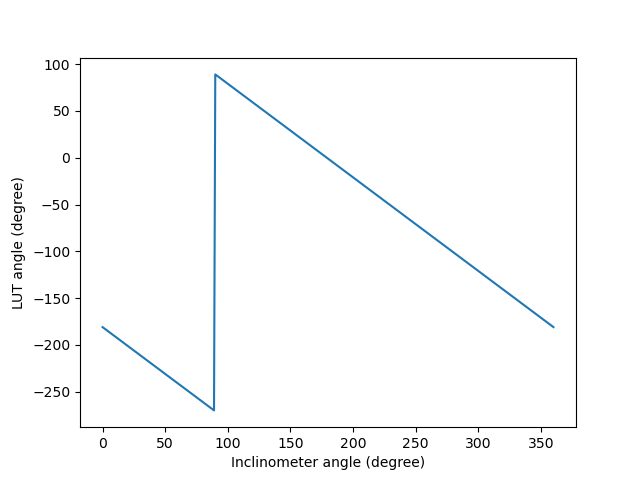

In [11]:
plt.figure()
plt.plot(inclinometer_angles, lut_angles)
plt.xlabel("Inclinometer angle (degree)")
plt.ylabel("LUT angle (degree)")
plt.show()

## Check the Forces to Bear the Mirror's Weight

Check the theoretical actuator force to bear the mirror's weight: **1588.65 kg** (this is what I could find in the vendor's document. Not sure this is the actual mass or not. I suppose this value should be closed to the actual value).
All the axial actuators are considered to take the same force.
For the tangent links, A1 and A4 do not bear the weight of mirror.
A2 and A3 are in the same group.
A5 and A6 are in the same group and have the reversed direction of A2 and A3 to support the mirror.

In [12]:
forces_mirror_weight = np.zeros([3, len(inclinometer_angles)])
for idx, inclinometer_angle in enumerate(inclinometer_angles):
    force_mirror_weight = control_open_loop.get_forces_mirror_weight(inclinometer_angle)
    forces_mirror_weight[:, idx] = force_mirror_weight[[0, 73, 76]]
    
print(f"The maximum axial force is {max(forces_mirror_weight[0,:])} N.")
print(f"The maximum tangential force is {max(forces_mirror_weight[1,:])} N.")

The maximum axial force is 216.2327981037139 N.
The maximum tangential force is 3892.19036586685 N.


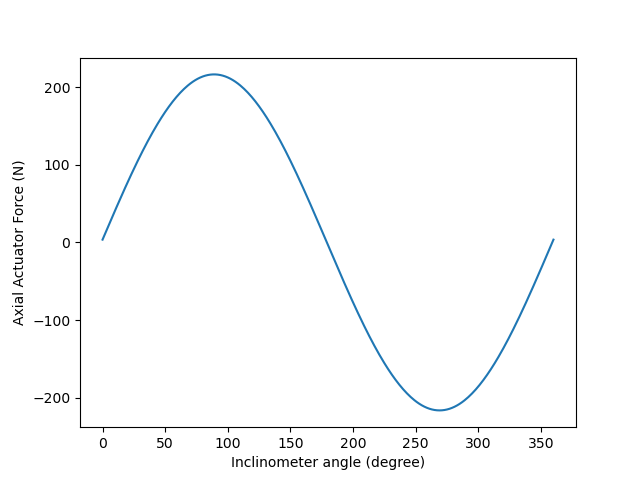

In [13]:
plt.figure()
plt.plot(inclinometer_angles, forces_mirror_weight[0, :])
plt.xlabel("Inclinometer angle (degree)")
plt.ylabel("Axial Actuator Force (N)")
plt.show()

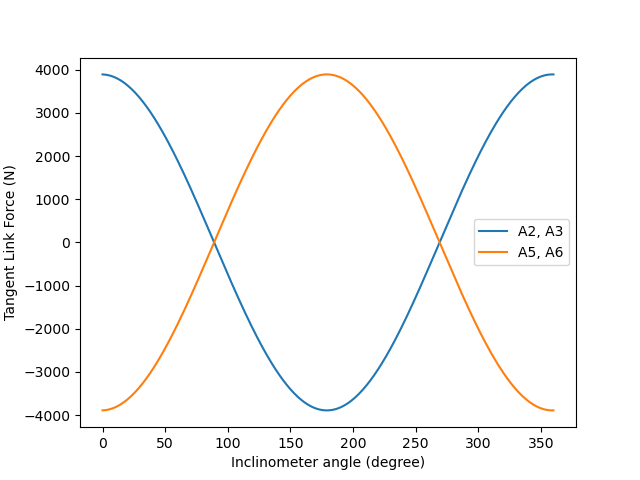

In [14]:
plt.figure()
plt.plot(inclinometer_angles, forces_mirror_weight[1, :])
plt.plot(inclinometer_angles, forces_mirror_weight[2, :])
plt.legend(["A2, A3", "A5, A6"])
plt.xlabel("Inclinometer angle (degree)")
plt.ylabel("Tangent Link Force (N)")
plt.show()

In [ ]:
@interact(inclinometer_angle=(0, 360, 1))
def check_forces_mirror_weight(inclinometer_angle):
    num_axial_actuatos = NUM_ACTUATOR - NUM_TANGENT_LINK
    axial_total = forces_mirror_weight[0, int(inclinometer_angle)] * num_axial_actuatos

    tangent_total = np.abs(forces_mirror_weight[1, int(inclinometer_angle)]) * 4
    
    print(f"Total axial force is {axial_total:.2f} N.")
    print(f"Total tangential force is {tangent_total:.2f} N.")

    print(f"Tangent force (A2 + A3) is {forces_mirror_weight[1, int(inclinometer_angle)] * 2:.2f} N.")
    print(f"Tangent force (A5 + A6) is {forces_mirror_weight[2, int(inclinometer_angle)] * 2:.2f} N.")

## Check the LUT Correction

Under the closed-loop control, the LUT correction (gravity + temperature) is applied.

In [15]:
config_path = Path.home() / "WORK" / "ts_mtm2" / "config" / "parameter_files"

filepath_surrogate = config_path / "luts" / "FinalHandlingLUTs"
filepath_mirror = config_path / "luts" / "FinalOpticalLUTs"

filepath_hardpoint_surrogate = config_path / "closed_loop_controller" / "CtrlParameterFiles_2018-07-19_104314_surg" / "Hd_ax_Matrix_Params.csv"
filepath_hardpoint_mirror = config_path / "closed_loop_controller" / "CtrlParameterFiles_2018-07-19_104257_m2" / "Hd_ax_Matrix_Params.csv"

filepath_cell_geom = Path.home() / "WORK" / "ts_mtm2" / "config" / "cellGeom.json"

In [16]:
control_closed_loop_surrogate = MockControlClosedLoop()
control_closed_loop_surrogate.load_file_lut(filepath_surrogate)
control_closed_loop_surrogate.load_file_cell_geometry(filepath_cell_geom)
control_closed_loop_surrogate.load_file_hardpoint_compensation(filepath_hardpoint_surrogate)

control_closed_loop_mirror = MockControlClosedLoop()
control_closed_loop_mirror.load_file_lut(filepath_mirror)
control_closed_loop_mirror.load_file_cell_geometry(filepath_cell_geom)
control_closed_loop_mirror.load_file_hardpoint_compensation(filepath_hardpoint_mirror)

### Calculate the forces.

The demanded force is defined to be "active optics correction" + LUT correction.
Consider the condition that there is no active optics correction first.
In the calculation of LUT temperature correction, only consider the normal case in the simulator, which has the 24.49 and 26.53 degree Celsius as a simplified condition.

In [19]:
forces_demanded_surrogate, hardpoint_correction_surrogate, forces_measured_surrogate = calculate_forces(
    control_closed_loop_surrogate, lut_angles, forces_mirror_weight)

forces_demanded_mirror, hardpoint_correction_mirror, forces_measured_mirror = calculate_forces(
    control_closed_loop_mirror, lut_angles, forces_mirror_weight)

print("Max measured forces in axial and tangential direction of surrogate are "
      f"{np.max(np.abs(forces_measured_surrogate[:-NUM_TANGENT_LINK,:])):.2f} N and "
      f"{np.max(np.abs(forces_measured_surrogate[-NUM_TANGENT_LINK:,:])):.2f} N.")

print("Max measured forces in axial and tangential direction of mirror are "
      f"{np.max(np.abs(forces_measured_mirror[:-NUM_TANGENT_LINK,:])):.2f} N and "
      f"{np.max(np.abs(forces_measured_mirror[-NUM_TANGENT_LINK:,:])):.2f} N.")

Max measured forces in axial and tangential direction of surrogate are 314.22 N and 3986.51 N.
Max measured forces in axial and tangential direction of mirror are 485.33 N and 3986.51 N.


Based on the above calculation, the theoretical axail force can be more than the default threshold.
However, this calculation is a simplified model, and need to use the real measurement to evaluate the difference between the real forces and theoretical forces.
But it is clear that the buffer of mirror safety might be tight at certain inclinometer angles.

#### Surrogate

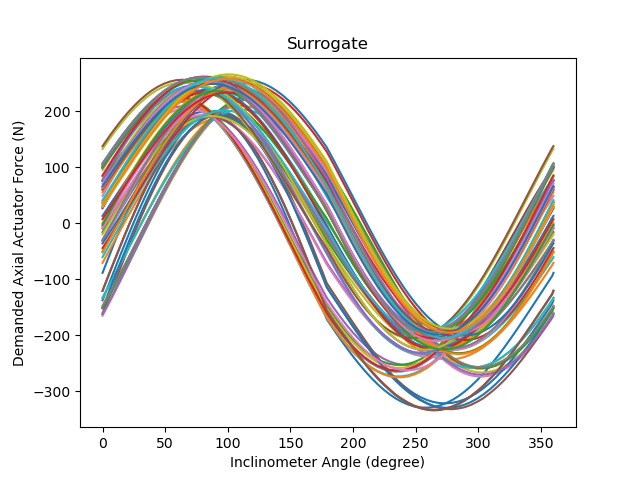

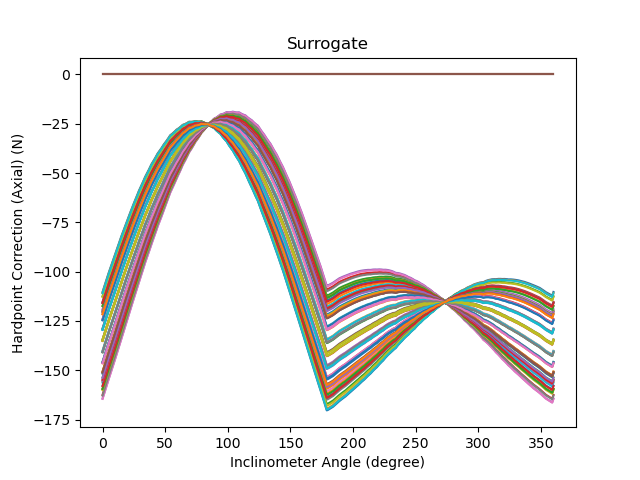

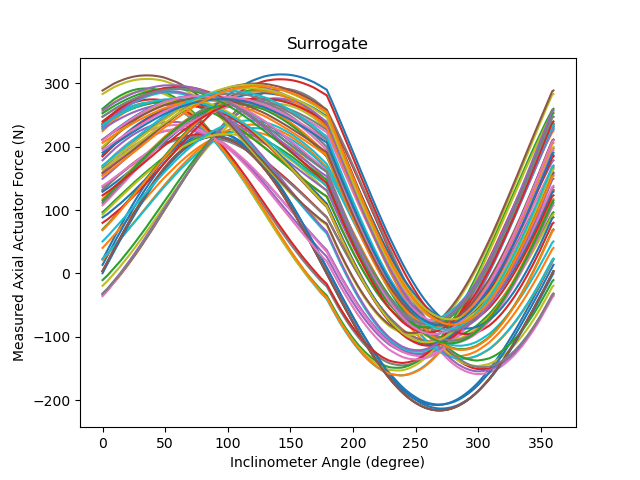

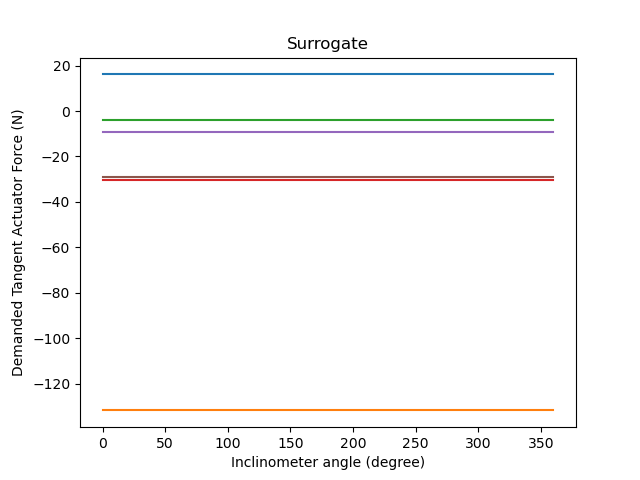

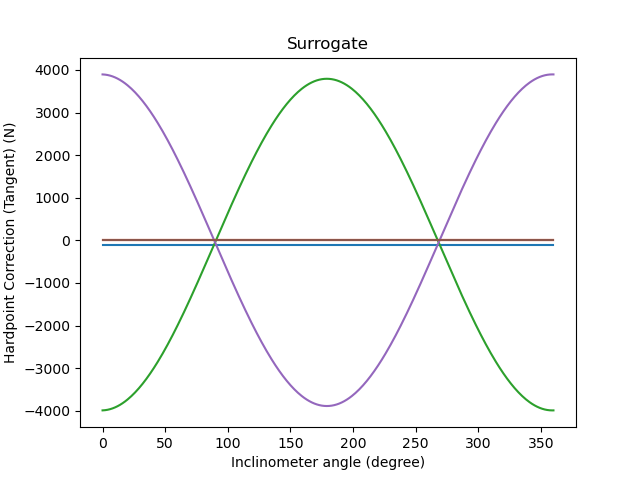

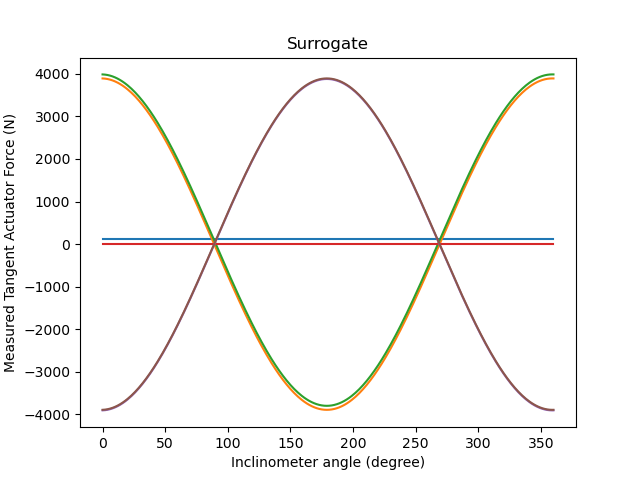

In [20]:
plot_forces(inclinometer_angles, forces_demanded_surrogate, hardpoint_correction_surrogate,
            forces_measured_surrogate, "Surrogate")

In the above figure, it is clear that the hardpoint correction is different between 0-180 degree and 180-360 degree regions, which implies the orientation of mirror is face-up or face-down.

#### Mirror

In [ ]:
plot_forces(inclinometer_angles, forces_demanded_mirror, hardpoint_correction_mirror,
            forces_measured_mirror, "Mirror")

## Check the Factory Force Offset (F_F.csv)

The LUT tables (8 csv files) between surrogate and mirror are basically the same except the file of **F_F.csv**.
For the surrogate, all the values in **F_F.csv** are zero.
For the mirror, the values are based on the measurement mentioned in: **03_M2_correctability_analysis.pdf**.

Calculate the factory force offset under different inclinometer angle in the following and draw the figure.

In [21]:
forces_factory_offset_mirror = np.zeros([NUM_ACTUATOR, len(inclinometer_angles)])

for idx, lut_angle in enumerate(lut_angles):

    force_factory_offset = np.zeros(NUM_ACTUATOR)
    for idx_act in range(NUM_ACTUATOR - NUM_TANGENT_LINK):
        force_factory_offset[idx_act] = np.interp(
            lut_angle,
            control_closed_loop_mirror._lut["lutInAngle"],
            control_closed_loop_mirror._lut["F_F"][idx_act, :]
        )

    forces_factory_offset_mirror[:, idx] = force_factory_offset

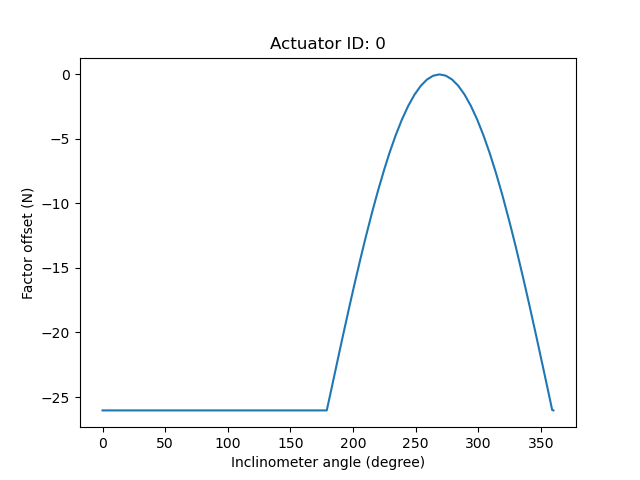

In [22]:
idx_act = 0

plt.figure()
plt.plot(inclinometer_angles, forces_factory_offset_mirror[idx_act, :])
plt.xlabel("Inclinometer angle (degree)")
plt.ylabel("Factor offset (N)")
plt.title(f"Actuator ID: {idx_act}")
plt.show()

## Active Optics Correction

Every 15 seconds, the active optics system (AOS) will apply the maximum 20 bending modes to M2 to improve the image quality.
In the optical feedback control (OFC), the penality of M2 correction is high, and the priority to apply the M2 bending mode might be low.
Under the current simulation of active optics system, the maximum 5% M1M3 actuator force error is applied, and the amplitude of M2 bending mode correction is between 0.1 um and 1e-5 um. 

In [23]:
bending_mode_file = get_config_dir_ofc() / "M2" / "M2_1um_72_force.yaml"
with open(bending_mode_file, "r") as yaml_file:
    bending_mode = np.array(yaml.safe_load(yaml_file))

for idx in range(1, 21):
    print(f"Maximum force in bending mode (1 um): '{idx}' is {np.max(np.abs(bending_mode[:, 2+idx])):.2f} N.")

Maximum force in bending mode (1 um): '1' is 0.52 N.
Maximum force in bending mode (1 um): '2' is 0.52 N.
Maximum force in bending mode (1 um): '3' is 3.70 N.
Maximum force in bending mode (1 um): '4' is 4.04 N.
Maximum force in bending mode (1 um): '5' is 6.81 N.
Maximum force in bending mode (1 um): '6' is 16.52 N.
Maximum force in bending mode (1 um): '7' is 16.30 N.
Maximum force in bending mode (1 um): '8' is 14.06 N.
Maximum force in bending mode (1 um): '9' is 14.11 N.
Maximum force in bending mode (1 um): '10' is 29.77 N.
Maximum force in bending mode (1 um): '11' is 29.94 N.
Maximum force in bending mode (1 um): '12' is 34.96 N.
Maximum force in bending mode (1 um): '13' is 34.47 N.
Maximum force in bending mode (1 um): '14' is 57.85 N.
Maximum force in bending mode (1 um): '15' is 68.72 N.
Maximum force in bending mode (1 um): '16' is 74.28 N.
Maximum force in bending mode (1 um): '17' is 71.26 N.
Maximum force in bending mode (1 um): '18' is 205.09 N.
Maximum force in bendin

In [ ]:
plot_bending_mode_forces(bending_mode, 1, 1)

### Data Visualization

Do the interactive drawing to have the idea of force distribution.

Get the x, y position of actuators.

In [24]:
# Axial actuators
xy_axial = np.array(control_closed_loop_surrogate._cell_geom["locAct_axial"])

# Tangent links
radius = control_closed_loop_surrogate._cell_geom["radiusActTangent"]
angle_radian = np.deg2rad(control_closed_loop_surrogate._cell_geom["locAct_tangent"])

xy_tangent = np.zeros([NUM_TANGENT_LINK, 2])
xy_tangent[:, 0] = radius * np.cos(angle_radian)
xy_tangent[:, 1] = radius * np.sin(angle_radian)

xy_actuators = np.zeros([NUM_ACTUATOR, 2])
xy_actuators[:-NUM_TANGENT_LINK, :] = xy_axial
xy_actuators[-NUM_TANGENT_LINK:, :] = xy_tangent

In [ ]:
@interact(idx=(1, 20), amplitude=(0, 1, 0.01))
def draw_bending_mode_forces_interactive(idx, amplitude):
    draw_bending_mode_forces(xy_actuators, bending_mode, idx, amplitude)

In [ ]:
@interact(inclinometer_angle=(0, 360, 1))
def draw_forces_interactive(inclinometer_angle):
    max_force_axial, max_force_tangent = draw_forces(
        xy_actuators, forces_measured_surrogate, inclinometer_angle, "Surrogate")
    print(f"Maximum axial force magnitude: {max_force_axial:0.2f} N")
    print(f"Maximum tangential force magnitude: {max_force_tangent:0.2f} N")

In [ ]:
@interact(inclinometer_angle=(0, 360, 1))
def draw_forces_interactive(inclinometer_angle):
    max_force_axial, max_force_tangent = draw_forces(
        xy_actuators, forces_measured_mirror, inclinometer_angle, "Mirror")
    print(f"Maximum axial force magnitude: {max_force_axial:0.2f} N")
    print(f"Maximum tangential force magnitude: {max_force_tangent:0.2f} N")

In [25]:
@interact(inclinometer_angle=(0, 360, 1))
def draw_forces_interactive(inclinometer_angle):
    max_force_axial, max_force_tangent = draw_forces(
        xy_actuators, forces_factory_offset_mirror, inclinometer_angle, "Mirror")
    print(f"Maximum axial force magnitude (factory offset): {max_force_axial:0.2f} N")
    print(f"Maximum tangential force magnitude (factory offset): {max_force_tangent:0.2f} N")

interactive(children=(IntSlider(value=180, description='inclinometer_angle', max=360), Output()), _dom_classes…

### Check the Net Forces and Moments

In [ ]:
net_force_moment_surrogate = calculate_net_force_moment(
    control_closed_loop_surrogate, forces_measured_surrogate)
net_force_moment_mirror = calculate_net_force_moment(
    control_closed_loop_mirror, forces_measured_mirror)

print(f"Max fx (Surrogate): {np.max(np.abs(net_force_moment_surrogate[0, :])):0.2f} N.")
print(f"Max fy (Surrogate): {np.max(np.abs(net_force_moment_surrogate[1, :])):0.2f} N.")
print(f"Max fz (Surrogate): {np.max(np.abs(net_force_moment_surrogate[2, :])):0.2f} N.")

print(f"Max mx (Surrogate): {np.max(np.abs(net_force_moment_surrogate[3, :])):0.2f} N*m.")
print(f"Max my (Surrogate): {np.max(np.abs(net_force_moment_surrogate[4, :])):0.2f} N*m.")
print(f"Max mz (Surrogate): {np.max(np.abs(net_force_moment_surrogate[5, :])):0.2f} N*m.")

print("")

print(f"Max fx (Mirror): {np.max(np.abs(net_force_moment_mirror[0, :])):0.2f} N.")
print(f"Max fy (Mirror): {np.max(np.abs(net_force_moment_mirror[1, :])):0.2f} N.")
print(f"Max fz (Mirror): {np.max(np.abs(net_force_moment_mirror[2, :])):0.2f} N.")

print(f"Max mx (Mirror): {np.max(np.abs(net_force_moment_mirror[3, :])):0.2f} N*m.")
print(f"Max my (Mirror): {np.max(np.abs(net_force_moment_mirror[4, :])):0.2f} N*m.")
print(f"Max mz (Mirror): {np.max(np.abs(net_force_moment_mirror[5, :])):0.2f} N*m.")

The difference of moment y between the surrogate and mirror is very large.
I do not understand why.

#### Surrogate

In [ ]:
plot_net_force_moment(inclinometer_angles, net_force_moment_surrogate, "Surrogate")

#### Mirror

In [ ]:
plot_net_force_moment(inclinometer_angles, net_force_moment_mirror, "Mirror")

I begin to suspect the LUT/parameters files of mirror have the problems based on the figure of y-moment.
The other possiblity is that only the LUT of 180-360 degree region is used.

### Bump Test

This is to simulate the actuator force feedback when a certain actuator is applied with the bump test.

In [26]:
applied_forces = create_applied_forces(10, -30)

In [27]:
forces_demanded_surrogate_applied, hardpoint_correction_surrogate_applied, forces_measured_surrogate_applied = calculate_forces(
    control_closed_loop_surrogate, lut_angles, forces_mirror_weight, applied_forces=applied_forces)

In [28]:
@interact(inclinometer_angle=(0, 360, 1))
def draw_applied_forces_interactive(inclinometer_angle):
    max_force_axial_diff, max_force_tangent_diff = draw_forces(
        xy_actuators,
        forces_measured_surrogate_applied - forces_measured_surrogate,
        inclinometer_angle,
        "Surrogate"
    )
    print(f"Maximum axial force magnitude (difference): {max_force_axial_diff:0.2f} N")
    print(f"Maximum tangential force magnitude (difference): {max_force_tangent_diff:0.2f} N")

interactive(children=(IntSlider(value=180, description='inclinometer_angle', max=360), Output()), _dom_classes…

## Check the Stiff Matrices

For the hardpoint correction between the surrogate the mirror, the main difference is the stiff matrices.

In [29]:
stiff_mat_file_dir = Path.home() / "WORK" / "ts_mtm2_matlab_tools" / "ReferenceFiles"

stiff_mat_file_surrogate = stiff_mat_file_dir / "StiffnessMatrix_Surrogate.mat"
stiff_mat_file_mirror = stiff_mat_file_dir / "StiffnessMatrix_M2.mat"

In [30]:
stiff_mat_surrogate = loadmat(stiff_mat_file_surrogate.as_posix())["stiff"]
stiff_mat_mirror = loadmat(stiff_mat_file_mirror.as_posix())["stiff"]

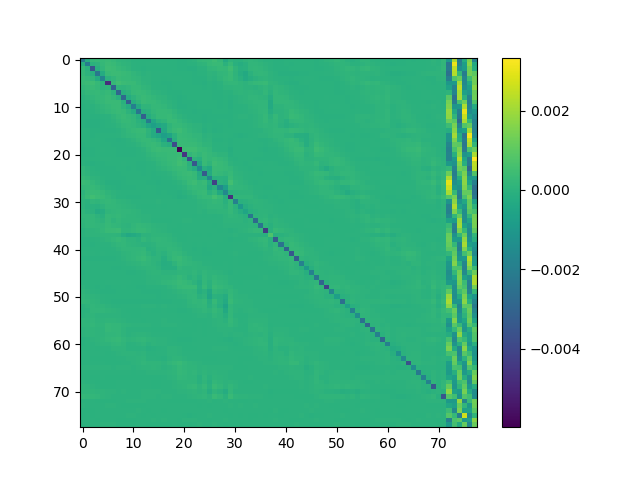

In [31]:
fig = plt.figure()
diff_mat = plt.imshow(stiff_mat_mirror-stiff_mat_surrogate, aspect="auto")
fig.colorbar(diff_mat)
plt.show()

In [ ]:
plt.close("all")